In [40]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']
    
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch 
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.data = 'custom' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.root_path = '' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.data_path = 'only_sentiment_nrml.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Close_diff' # target feature in S or MS task
args.freq = 'd' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 100 # input sequence length of Informer encoder
args.label_len = 100 # start token length of Informer decoder
args.pred_len = 50 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
# args.enc_in = 202 # encoder input size
args.dec_in = 7 # decoder input size
# args.dec_in = 202 # decoder input size
args.c_out = 7 # output size
# args.c_out = 202 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
# args.d_model = 1512 # dimension of model
args.n_heads = 50 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'd'

args.batch_size = 32 
args.learning_rate = 0.001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 2
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'custom':{'data':'only_sentiment_nrml.csv','T':'Close_diff','M':[22,22,22],'S':[1,1,1],'MS':[22,22,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]
    
args.detail_freq = args.freq
args.freq = args.freq[-1:]

Exp = Exp_Informer
exp = Exp(args)

Use CPU


In [41]:
import os
# setting = 'informer_custom_ftMS_sl300_ll300_pl150_dm128_nh10_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
setting = 'informer_custom_ftMS_sl100_ll100_pl50_dm512_nh50_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
exp = Exp(args)

Use CPU


In [42]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        print(batch_y.shape)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds, batch_y


In [43]:
import numpy as np
# you can also use this prediction function to get result
prediction, true = predict(exp, setting, True)
print(prediction.shape)
print(true.shape)

datapath ==  only_sentiment_nrml.csv
torch.Size([1, 100, 22])
(1, 50, 1)
torch.Size([1, 50, 1])


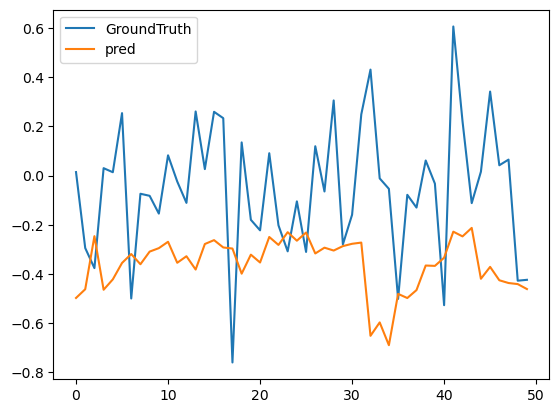

In [44]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(true[0,:,-1], label='GroundTruth')

plt.plot(10*prediction[0,:,-1], label='pred')
plt.legend()
plt.show()

In [45]:
import pandas as pd
df1 = pd.read_csv('only_sentiment.csv')

In [46]:
df1 = df1.set_index("date")

In [47]:
df1.tail()

,day_1_neg,day_1_neu,day_1_pos,week_1_neg,week_1_neu,week_1_pos,month_1_neg,month_1_neu,month_1_pos,year_1_neg,...,rest_neg,rest_neu,rest_pos,Open,High,Low,Close,Adj Close,Volume,Close_diff
date,,,,,,,,,,,,,,,,,,,,,
10/21/2022,0.199972,0.581658,0.218371,0.175915,0.522700,0.301385,0.246392,0.506453,0.247155,0.251317,...,0.236945,0.571056,0.191999,114.790001,119.589996,114.500000,119.320000,119.320000,55611900,0.341100
10/24/2022,0.003193,0.544831,0.451976,0.125043,0.559815,0.315142,0.224007,0.509109,0.266884,0.250272,...,0.236815,0.571034,0.192151,119.980003,120.389999,116.570000,119.820000,119.820000,49531500,0.041729
10/25/2022,0.290564,0.507718,0.201719,0.144838,0.554684,0.300478,0.228403,0.511485,0.260112,0.250786,...,0.236829,0.571019,0.192152,119.650002,121.320000,118.949997,120.599998,120.599998,50934600,0.064676
10/26/2022,0.423866,0.462804,0.113330,0.157855,0.565284,0.276861,0.230118,0.511833,0.258049,0.250804,...,0.236844,0.571011,0.192145,116.000000,119.349998,114.760002,115.660004,115.660004,68802300,-0.427113
10/27/2022,0.221323,0.489873,0.288805,0.155012,0.520208,0.324780,0.229989,0.510796,0.259215,0.251544,...,0.236837,0.570978,0.192186,113.919998,114.120003,109.769997,110.959999,110.959999,129605400,-0.423577


<AxesSubplot:xlabel='date'>

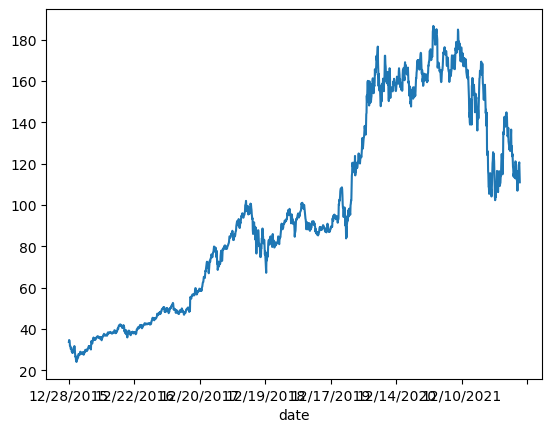

In [48]:
df1['Close'].plot()

In [49]:
new_pred = prediction[0,:,-1]

In [50]:
Start_price = df1["Close"][-51:-50][0]

In [ ]:
prediction_close_price = [Start_price]
new_price = Start_price
for i in new_pred:
    print(new_price)
    new_price = new_price + (new_price*i/10)
    if(i<0):
        print('here')
    print(new_price)
    prediction_close_price.append(new_price)
print(prediction_close_price)

In [52]:
prediction_close_price = list(df1['Close'][0:-50]) + list(prediction_close_price)


In [63]:
prediction_close_price_copy = prediction_close_price.copy()

In [64]:
prediction_close_price_copy = prediction_close_price_copy[-500:]

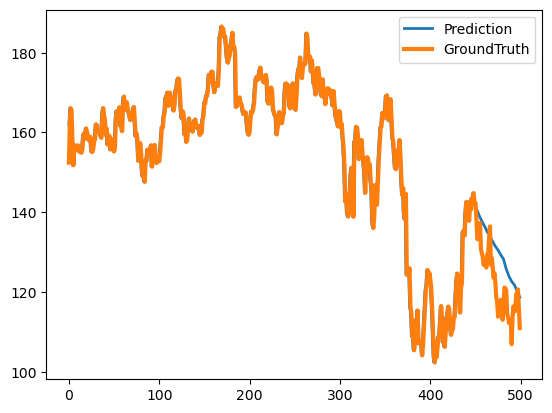

In [67]:
plt.figure()

plt.plot(prediction_close_price_copy, label='Prediction', linewidth=2)
plt.plot(list(df1['Close'][-500:]), label='GroundTruth', linewidth=3)

plt.legend()
plt.show()